In [1]:
import numpy as np
import pylab as pl
import tensorflow as tf
import matplotlib.gridspec as gridspec
%matplotlib inline

train = np.concatenate([np.loadtxt('train6_12345.txt' ),
                        np.loadtxt('train6_6789.txt'  ),
                        np.loadtxt('train6_101112.txt')])
label = np.concatenate([np.loadtxt('label6_12345.txt' ),
                        np.loadtxt('label6_6789.txt'  ),
                        np.loadtxt('label6_101112.txt')]).reshape(-1,1)
print(train.shape, label.shape)

(5461, 273) (5461, 1)


In [2]:
cov = 1/len(train)*np.dot((train-train.mean(0)).T, train-train.mean(0))
u,s,v = np.linalg.svd(cov)
restriction = 43
print(s[:restriction].sum()/s.sum())
U = u[:,:restriction]
reduction = np.dot(train, U)
Max, Min = np.max(label), np.min(label)
print(reduction.shape)

0.9900768859325789
(5461, 43)


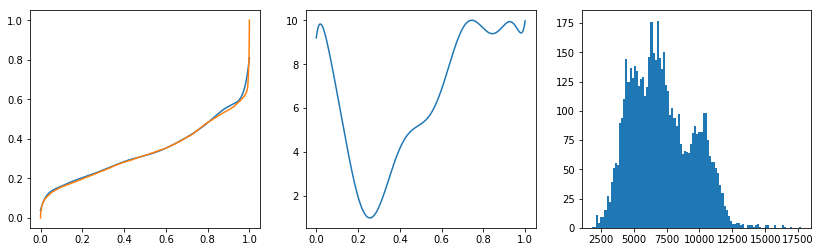

In [3]:
def FFN(TraX, TraY, TesX, TesY, learning_rate, iterations, dim, act): 
    fn1 = tf.nn.sigmoid
    fn2 = tf.nn.relu
    ac  = [fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1,fn1] # number of entry = len(dim) - 2

    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, TraX.shape[1]])
    Y = tf.placeholder(tf.float32, [None, TraY.shape[1]])
        
    W = [ tf.Variable(tf.random_normal([dim[i], dim[i+1]])) for i in range(len(dim) - 1) ]
    b = [ tf.Variable(tf.random_normal([dim[i+1]]))         for i in range(len(dim) - 1) ]
    A = [X]
    for i in range(len(dim) - 2):
        A.append(ac[i](tf.matmul(A[-1],W[i]) + b[i]))
    A.append(tf.matmul(A[-1], W[-1]) + b[-1])  
    if act == 0:
        cost = tf.sqrt(tf.reduce_mean(tf.reduce_mean(tf.square(Y - A[-1]) ))) 
    if act == 1:
        cost = tf.sqrt(tf.reduce_mean(tf.reduce_mean(tf.square(Y - A[-1])*error_function(Y,label,100,12,1,3) ))) 
    gogo = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    real = tf.placeholder(tf.float32, [None, TraY.shape[1]])
    pred = tf.placeholder(tf.float32, [None, TraY.shape[1]])
    rmse = tf.sqrt(tf.reduce_mean(tf.reduce_mean(tf.square(real - pred))))
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    for iteration in range(iterations):
        feed1 = {X:TraX, Y:TraY}
        sess.run(gogo, feed_dict = feed1)
        training_error = sess.run(cost , feed_dict = feed1)
        prediction     = sess.run(A[-1], feed_dict = {X:TesX})
        test_error     = sess.run(rmse , feed_dict = {real:TesY, pred:prediction})
        if iteration % int(iterations/5) == 0:    
            print('Training Error:',training_error,'and','Testing Error:', test_error) 
    return prediction
def Figure(Label, Prediction, bins):
    recover_testY = (Max-Min)*Label.flatten()      + Min
    recover_pred  = (Max-Min)*Prediction.flatten() + Min
    pl.figure(figsize=(15,15))
    gs = gridspec.GridSpec(2,2, width_ratios=[1,1], height_ratios=[1,1])
    
    pl.subplot(gs[0,:])
    pl.plot(recover_testY/1000, c='r', label ='Observation')
    pl.plot(recover_pred /1000, c='b', label ='Prediction')
    pl.ylabel('height(km)')
    pl.legend()
    print('RMSE:'     , np.round(rmse(Label, Prediction) , 4))
    print('real RMSE:', np.round(Rmse(Label, Prediction) , 4))
    print('CC:'       , np.round(  cc(Label, Prediction) , 4))
    
    pl.subplot(gs[2]) # values prediction and testY are between -4 and 4
    aa = recover_pred
    bb = recover_testY
    interval           = np.array([ Min + (Max - Min)/bins*i for i in range(bins+1) ])
    interval1          = np.array([ Min + (Max - Min)/bins*i for i in range(bins+1) ])
    revised_interval   = interval[:-1]  + (Max - Min)/(2*bins)
    revised_interval1  = interval1[:-1] + (Max - Min)/(2*bins)
    cumulative_number  = []
    cumulative_number1 = []
    for i in range(bins):
        cumulative_number.append(  (aa < interval[i+1] ).sum() - (aa < interval[i] ).sum() )
        cumulative_number1.append( (bb < interval1[i+1]).sum() - (bb < interval1[i]).sum() )
    pl.plot(revised_interval/1000          , cumulative_number   , color='green', alpha=0.5, label='Prediction')    
    pl.fill_between(revised_interval/1000  , cumulative_number, 0, color='green', alpha=0.5)
    pl.plot(revised_interval1/1000         , cumulative_number1  , color='red'  , alpha=0.5 ,label='Observation')    
    pl.fill_between(revised_interval1/1000 ,cumulative_number1, 0, color='red'  , alpha=0.5)
    pl.ylabel('number of samples')
    pl.xlabel('height(km)')
    pl.legend() 
    pl.title('Distribution')
    pl.legend()
    
    pl.subplot(gs[3])
    pl.scatter(recover_testY/1000, recover_pred/1000,s=3)
    pl.plot(np.arange(18000)/1000,np.arange(18000)/1000,c='black',linestyle = ':')
    pl.axis([0,18,0,18])
    pl.xticks([0,5,10,15])
    pl.yticks([0,5,10,15])
    pl.xlabel('Observation(km)')
    pl.ylabel('Prediction(km)')
    pl.title('Correlation')
    pl.grid()
def error_function(x, data, bins, degree, Min, Max):
    vec       = ((data - np.min(data,0))/(np.max(data,0)-np.min(data,0)))
    interval  = [ i/bins for i in range(bins + 1)]
    frequency = np.array([ ((vec<=interval[i+1]).sum() - (vec<interval[i]).sum())/len(vec) for i in range(bins) ])
    xx        = np.arange(bins)/(bins - 1)
    mat       = np.concatenate([(xx**i).reshape(-1,1) for i in range(degree)], axis=1)
    coef      = np.dot(np.linalg.inv(np.dot(mat.T,mat)), np.dot(mat.T, frequency))
    poly      = 1 - sum([coef[i]*(x**i) for i in range(degree)])
    values    = 1 - sum([coef[i]*(xx**i) for i in range(degree)])
    M, N      = np.max(values), np.min(values)
    return (Max - Min)/(M - N)*(poly - N) + Min 
def uniformize(reduction, label):
    mat = np.concatenate([reduction, label], axis=1)
    temporary = []
    for i in range(mat.shape[1]):
        a = np.arange(len(mat)).reshape(-1,1)
        b = np.concatenate([a,mat[:,[i]]], axis=1)
        c = b[b[:,1].argsort()]
        c[:,1] = np.arange(len(mat))/(len(mat)-1)
        d = c[c[:,0].argsort()]
        temporary.append(d[:,1])
    input_data = (np.array(temporary).T)[:, :-1]
    target     = (np.array(temporary).T)[:,[-1]]
    return input_data, target
def rmse(x,y):
    x = x.flatten()
    y = y.flatten()
    return np.sqrt((((x-y))**2).mean())
def Rmse(x,y):
    return np.sqrt( ( ( ((Max-Min)*x+Min).flatten()-((Max-Min)*y+Min).flatten() )**2 ).mean() )
def cc(x,y):
    return np.corrcoef( x.flatten(), y.flatten() )[0,1]
def sort(x):
    return np.sort(x.flatten())
def unit(x):
    return (x-np.min(x,0))/(np.max(x,0)-np.min(x,0))
def f_act(x):
    degree = 12
    y_val = np.sort(unit(label.flatten()))
    X     = (np.arange(len(y_val))/(len(y_val)-1) )
    mat   = np.concatenate([(X**i).reshape(-1,1) for i in range(degree)], axis=1)
    coef  = np.dot(np.linalg.inv(np.dot(mat.T,mat)), np.dot(mat.T, y_val))
    poly  = sum([coef[i]*(x**i) for i in range(degree)])
    return poly
x = np.arange(100001)/100000
pl.figure(figsize=(14,4))
pl.subplot(131)
pl.plot(x,f_act(x))
pl.plot(np.arange(len(label))/(len(label)-1),np.sort(unit(label.flatten())))
pl.subplot(132)
pl.plot(x, error_function(x, label, 100, 12, 1, 10))
pl.subplot(133)
_,_,_ = pl.hist(label, 100)

In [5]:
# As usual
Train, Label = unit(reduction), unit(label)
ntrain       = int(0.7*len(reduction))
trainX, trainY, testX, testY = Train[:ntrain], Label[:ntrain], Train[ntrain:], Label[ntrain:]
print(trainX.shape, trainY.shape, testX.shape, testY.shape)
dim          = [trainX.shape[1], 10, 10, 10,  trainY.shape[1]]
rmse1, cc1 = [], []
for i in range(10):
    prediction   = FFN(trainX, trainY, testX, testY, 0.005, 1000, dim, 0)
    rmse1.append(Rmse(prediction, testY))
    cc1.append(     cc(prediction, testY))   

(3822, 43) (3822, 1) (1639, 43) (1639, 1)
Training Error: 1.001227 and Testing Error: 1.0168531
Training Error: 0.086865366 and Testing Error: 0.09549503
Training Error: 0.0715684 and Testing Error: 0.07759275
Training Error: 0.069670804 and Testing Error: 0.07505972
Training Error: 0.068412535 and Testing Error: 0.07438824
Training Error: 1.0095259 and Testing Error: 1.0273054
Training Error: 0.13666774 and Testing Error: 0.13569793
Training Error: 0.07487269 and Testing Error: 0.0812268
Training Error: 0.07060508 and Testing Error: 0.076543204
Training Error: 0.070093974 and Testing Error: 0.0766542
Training Error: 2.4289036 and Testing Error: 2.451178
Training Error: 0.14708498 and Testing Error: 0.14446121
Training Error: 0.11887411 and Testing Error: 0.12041436
Training Error: 0.072600834 and Testing Error: 0.07728155
Training Error: 0.07083706 and Testing Error: 0.07622538
Training Error: 0.6156857 and Testing Error: 0.6246121
Training Error: 0.082166515 and Testing Error: 0.0915

In [5]:
# Apply error function
Train, Label = unit(reduction), unit(label)
ntrain       = int(0.7*len(reduction))
trainX, trainY, testX, testY = Train[:ntrain], Label[:ntrain], Train[ntrain:], Label[ntrain:]
print(trainX.shape, trainY.shape, testX.shape, testY.shape)
dim          = [trainX.shape[1], 10, 10, 10,  trainY.shape[1]]
rmse2, cc2 = [], []
for i in range(10):
    prediction   = FFN(trainX, trainY, testX, testY, 0.005, 1000, dim, 1)
    rmse2.append(Rmse(prediction, testY))
    cc2.append(     cc(prediction, testY))

(3822, 43) (3822, 1) (1639, 43) (1639, 1)
Training Error: 2.2417443 and Testing Error: 1.7711965
Training Error: 0.19480357 and Testing Error: 0.14502245
Training Error: 0.104278244 and Testing Error: 0.08859724
Training Error: 0.09540578 and Testing Error: 0.07798686
Training Error: 0.09408911 and Testing Error: 0.076590315
Training Error: 0.5669461 and Testing Error: 0.44860664
Training Error: 0.104141735 and Testing Error: 0.08875808
Training Error: 0.09225884 and Testing Error: 0.075007245
Training Error: 0.09061929 and Testing Error: 0.0744399
Training Error: 0.08791071 and Testing Error: 0.07381461
Training Error: 1.3782951 and Testing Error: 1.0885007
Training Error: 0.11636089 and Testing Error: 0.10318126
Training Error: 0.09311948 and Testing Error: 0.07796903
Training Error: 0.089819886 and Testing Error: 0.07588767
Training Error: 0.0878836 and Testing Error: 0.074773945
Training Error: 2.5512598 and Testing Error: 2.04903
Training Error: 0.13527958 and Testing Error: 0.104

In [7]:
np.sort(rmse1)[:5].mean(), np.sort(rmse2)[:5].mean(), np.sort(cc1)[5:].mean(), np.sort(cc2)[5:].mean()

(1164.1729146420982, 1173.3595898317994, 0.8639619817384666, 0.865298337584445)

(3822, 43) (3822, 1) (1639, 43) (1639, 1)
RMSE: 0.0757
real RMSE: 1204.3392
CC: 0.8541


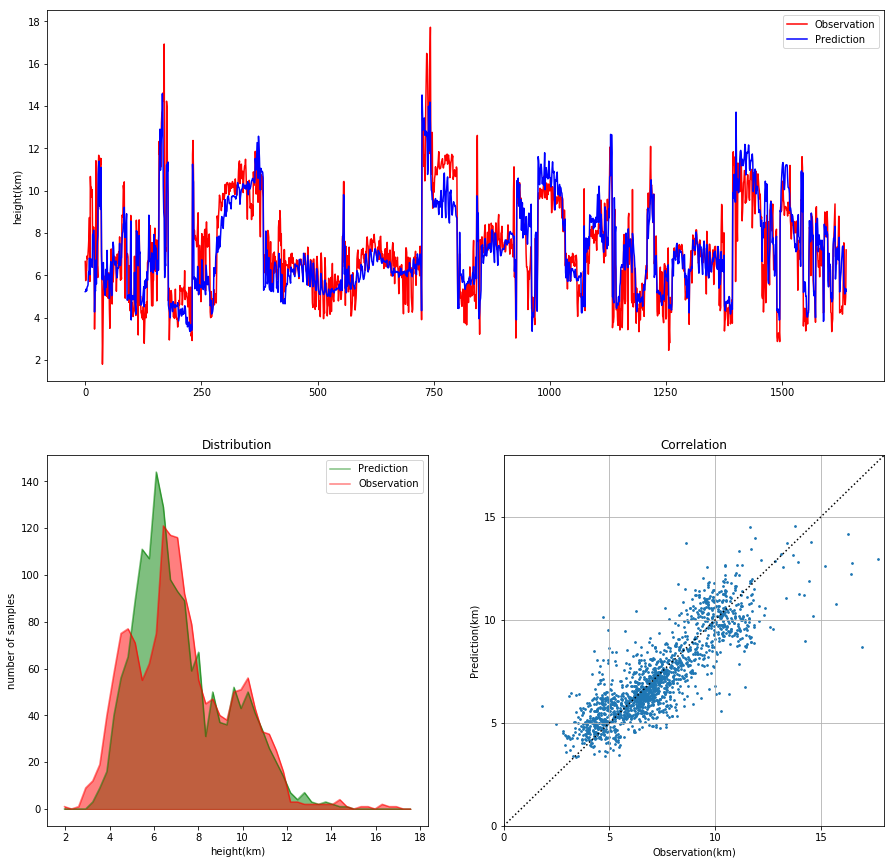

In [26]:
# As usual
Train, Label = unit(reduction), unit(label)
ntrain       = int(0.7*len(reduction))
trainX, trainY, testX, testY = Train[:ntrain], Label[:ntrain], Train[ntrain:], Label[ntrain:]
print(trainX.shape, trainY.shape, testX.shape, testY.shape)
dim          = [trainX.shape[1], 10, 10, 10,  trainY.shape[1]]
prediction   = FFN(trainX, trainY, testX, testY, 0.005, 1000, dim, 0)
Figure(testY, prediction, 50)

(3822, 43) (3822, 1) (1639, 43) (1639, 1)
rmse: 0.07480997817438177
Rmse: 1190.0512605589868
cc: 0.8606619604988156


(3822, 43) (3822, 1) (1639, 43) (1639, 1)
RMSE: 0.0742
real RMSE: 1179.7352
CC: 0.8617


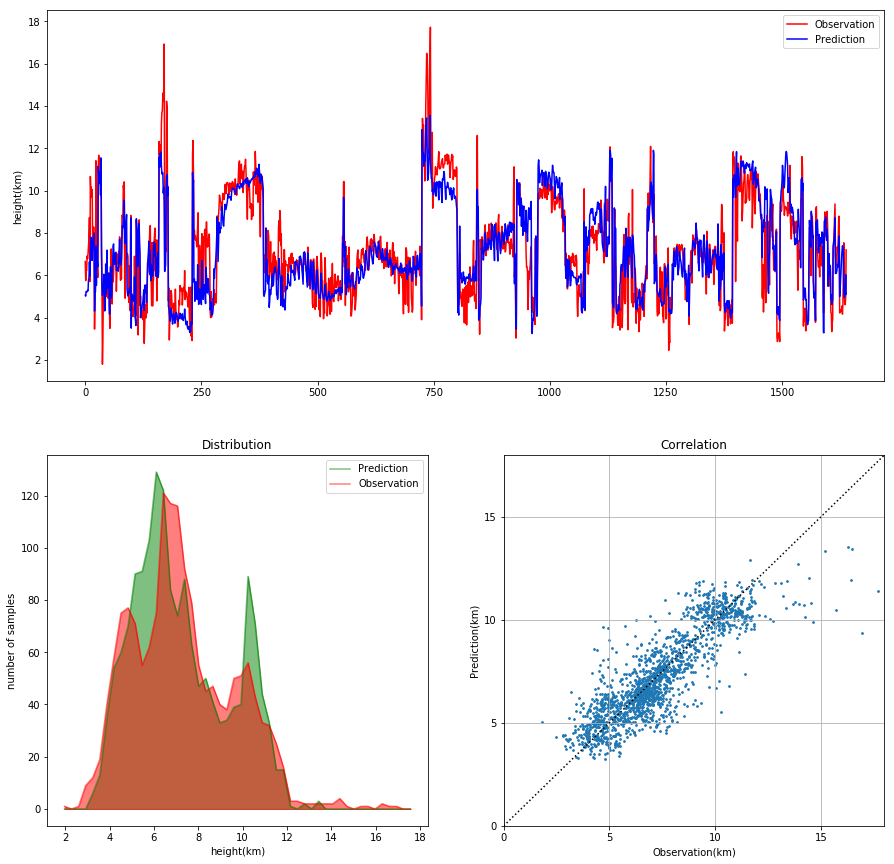

In [28]:
# Apply error function
Train, Label = unit(reduction), unit(label)
ntrain       = int(0.7*len(reduction))
trainX, trainY, testX, testY = Train[:ntrain], Label[:ntrain], Train[ntrain:], Label[ntrain:]
print(trainX.shape, trainY.shape, testX.shape, testY.shape)
dim          = [trainX.shape[1], 10, 10, 10,  trainY.shape[1]]
prediction   = FFN(trainX, trainY, testX, testY, 0.01, 1000, dim, 1)
Figure(testY, prediction, 50)